**Chapter 15 – Processing Sequences Using RNNs and CNNs**

**Chapter 16 – Natural Language Processing with RNNs and Attention**

_This notebook contains the sample from https://github.com/ageron/handson-ml2/ and https://github.com/fchollet/deep-learning-with-python-notebooks_

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/04_Recurrent Neural Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/04_Recurrent Neural Networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs for forecasting times series

## Generate the Dataset

Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step. This is called a time series. In the first two examples there is a single value per time step, so these are **univariate time series**, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a **multivariate time series**. A typical task is to predict future values, which is called forecasting. Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called imputation. 

For simplicity, we are using a time series generated by the generate_time_series() function, shown here:

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

The function returns a NumPy array of shape `[batch size, time steps, 1]`, where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise. 

When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape `[batch size, time steps, dimensionality]`,where dimensionality is 1 for univariate time series and more for multivariate
time series.


In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

`X_train` contains 7,000 time series (i.e., its shape is `[7000, 50, 1]`), while `X_valid` contains 2,000 (from the 7,000th time series to the 8,999th) and X_test contains 1,000 (from the 9,000 to the 9,999 ). **Since we want to
forecast a single value for each series**, the targets are column vectors (e.g., `y_train` has a shape of `[7000, 1]`).

Saving figure time_series_plot


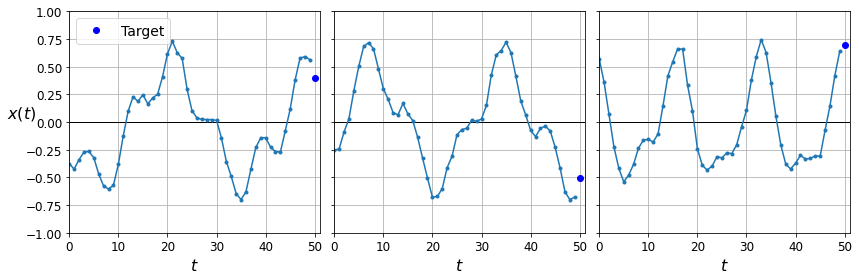

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

## Computing Some Baselines

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. The simplest approach is to predict the last value in each series. This is called *naive forecasting*

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

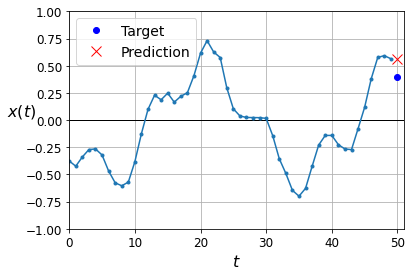

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a `Flatten layer`. Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 5ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0061 - val_loss: 0.0062

In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

If we compile this model using the MSE loss and the default Adam optimizer, then fit it on the training set for 20 epochs and evaluate it on the validation set, we get an MSE of about 0.004. That’s much better than the naive approach!

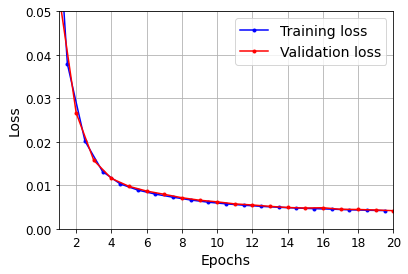

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

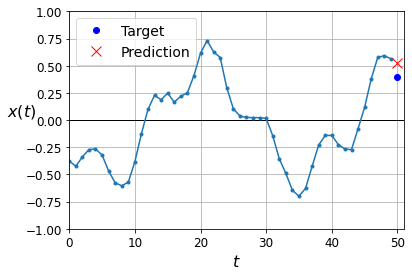

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Using a Simple RNN

Let’s see if we can beat that with a simple RNN. It just contains a single layer, with a single neuron. We do not need to specify the length of the input sequences (unlike in the previous model), **since a recurrent neural network can process any number of time steps** (this is why we set the first input dimension to None). By default, the SimpleRNN layer **uses the hyperbolic tangent activation function**. It works exactly as we saw earlier: the initial state $h_{init}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_0$. The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, $y_0$. In a simple RNN, this output is also the new state $h_0$. This new state is passed to the same recurrent neuron along with the next input value, $x_1$, and the process is repeated until the last time step. Then the layer just outputs the last value, $y_{49}$. All of this is performed simultaneously for every time series.

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters). In contrast, for each recurrent neuron in a simple
RNN, **there is just one parameter per input and per hidden state dimension** (in a simple RNN, that’s just the number of recurrent neurons in the layer),  plus a bias term.

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 13s 54ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 12s 53ms/step - loss: 0.011

In [16]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 8ms/step - loss: 0.0109


0.010881561785936356

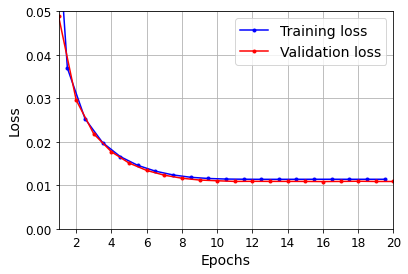

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

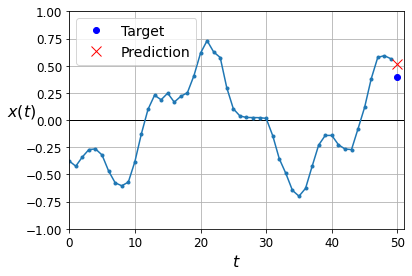

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

There are many other models to forecast time series, such as weighted moving average models or autoregressive integrated moving average (ARIMA) models. Some of them require you to first remove the trend and seasonality. Once the model is
trained and starts making predictions, you would have to add them back. When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the trend or the seasonality. 

## Deep RNNs

Implementing a deep RNN with `tf.keras` is quite simple: just stack recurrent layers. In this example, we use three SimpleRNN layers. Make sure to set `return_sequences=True` for all recurrent layers (except the last one, if you only care about the last output). **If you don’t, they will output a 2D array (containing only the output of the last time step)** instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

# By default, recurrent layers in Keras only return the final output. 
# To make them return one output per time step, you must set return_sequences=True
# number of parameters https://d2l.ai/chapter_recurrent-neural-networks/rnn.html#recurrent-neural-networks-with-hidden-states
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), #1*20+20+20*20
    keras.layers.SimpleRNN(20, return_sequences=True),  #20*20++20+20*20
    keras.layers.SimpleRNN(1) #20*1+1+1*1
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 41s 178ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 38s 173ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 47s 217ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 62s 282ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 54s 246ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 49s 226ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 37s 171ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 38s 172ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 54s 245ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 37s 169ms/step - l

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 3s 47ms/step - loss: 0.0029


0.002910560928285122

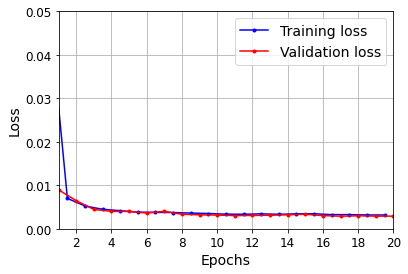

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

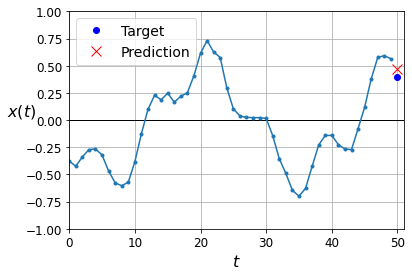

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Since a SimpleRNN layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1. It might be preferable to
replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. If you make this change, also make sure to remove `return_sequences=True` from the second (now last) recurrent layer

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


## Forecasting Several Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets
to be the value 10 steps ahead instead of 1 step ahead). But what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following
value, and so on, as in the following code:

In [25]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [26]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


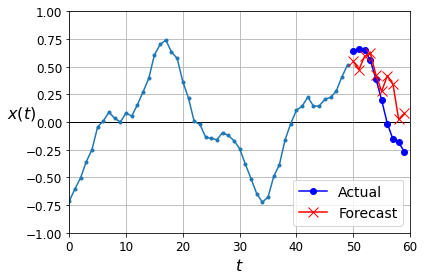

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

As you might expect, the prediction for the next step will usually be more accurate than the predictions for later time steps, since the errors might accumulate. If you only want to forecast a few time steps ahead, on more
complex tasks, this approach may work well.

In [28]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [29]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [30]:
Y_pred.shape

(2000, 10)

In [31]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.19622587

Let's compare this performance with some baselines: naive predictions:

In [32]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

The second option is to train an RNN to predict all 10 next values at once. We can still use a sequence-to-vector model, but it will output 10 values instead of 1. Now we just need the output layer to have 10 units instead of 1:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 34s 149ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 36s 164ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 25s 112ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 25s 112ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 36s 167ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 25s 112ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 24s 111ms/step - l

In [35]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

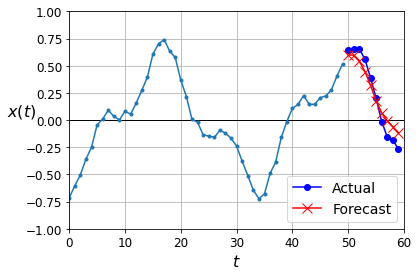

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

This model works nicely: the MSE for the next 10 time steps is about 0.008. That’s much better than predicted one by one. But we can still do better: indeed, instead of training the model to forecast the next 10 values only at the
very last time step, **we can train it to forecast the next 10 values at each and every time step.** In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step. This will both stabilize and speed up training.

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. So each target must be a sequence of the same
length as the input sequence, containing a 10-dimensional vector at each step. Let’s prepare these target sequences:

In [37]:
np.random.seed(42)

# Notice that the model is still causal: when it makes predictions at 
# any time step, it can only see past time steps.

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:,:, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [41]:
X_train.shape, Y_train.shape, series.shape

((7000, 50, 1), (7000, 50, 10), (10000, 60, 1))

To turn the model into a sequence-to-sequence model, we must set `return_sequences=True` in all recurrent layers (even the last one), and we must **apply the output Dense layer at every time step**. Keras offers a
`TimeDistributed` layer for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a
separate instance (i.e., it reshapes the inputs from `[batch size, time steps, input dimensions]` to `[batch size×time steps, input dimensions]`. In this example, the number of input dimensions is 20 because the previous SimpleRNN
layer has 20 units), then it runs the Dense layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from `[batch size × time steps, output dimensions]` to `[batch size, time steps, output dimensions]`; in this example the number of output dimensions is 10, since the Dense layer has 10 units). Here is the updated model:

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


It makes it clear that the Dense layer is applied independently at each time step and that the model will output a sequence, not just a single vector.

All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. So although we will rely on the MSE over all the outputs for training, we will use a custom metric for
evaluation, to only compute the MSE over the output at the last time step:

In [40]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 27s 115ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 24s 112ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 25s 112ms/step - loss: 0.0327 - last_time_step_mse: 0.0215 - val_loss: 0.0314 - val_last_time_step_mse: 0.0208
Epoch 4/20
219/219 [==============================] - 26s 118ms/step - loss: 0.0295 - last_time_step_mse: 0.0181 - val_loss: 0.0275 - val_last_time_step_mse: 0.0157
Epoch 5/20
219/219 [==============================] - 24s 112ms/step - loss: 0.0272 - last_time_step_mse: 0.0152 - val_loss: 0.0286 - val_last_time_step_mse: 0.0203
Epoch 6/20
219/219 [==============================] - 24s 111ms/step - loss: 0.0249 - last_time_step_mse: 0.0123 - val_loss: 0.0230 - val_last_time_step_mse: 0.0094
Epoch 7/20

In [42]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
model.evaluate(X_valid, Y_valid)

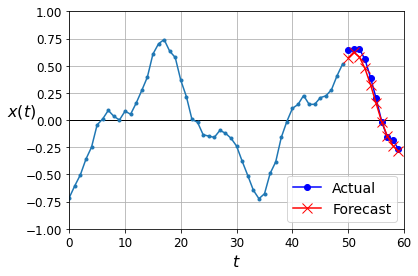

In [43]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

You might find https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array or https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator useful

## Deep RNNs with Layer Norm

Let’s use tf.keras to implement Layer Normalization within a simple memory cell. We need to define a custom memory cell. It is just like a regular layer, except its `call()` method takes two arguments: the inputs at the current time step and the hidden states from the previous time step. Note that the states argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short-term state). A cell must also have a `state_size` attribute and an `output_size` attribute. In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell which will behave like a SimpleRNNCell, except it will also apply Layer Normalization at each time step:

In [44]:
from tensorflow.keras.layers import LayerNormalization

In [46]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        # in a SimpleRNNCell, the outputs are just equal to the hidden states: new_states[0] is equal to outputs, 
        # so we can safely ignore new_states in the rest of the call() method.
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: all recurrent layers and all cells provided by Keras have a dropout hyperparameter and a recurrent_dropout hyperparameter: the **former defines the dropout rate to apply to the inputs** (at each time step), and the latter defines the **dropout rate for the hidden states** (also at each time step).

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 74s 317ms/step - loss: 0.1668 - last_time_step_mse: 0.1624 - val_loss: 0.0738 - val_last_time_step_mse: 0.0686
Epoch 2/20
219/219 [==============================] - 56s 254ms/step - loss: 0.0639 - last_time_step_mse: 0.0567 - val_loss: 0.0569 - val_last_time_step_mse: 0.0498
Epoch 3/20
219/219 [==============================] - 55s 251ms/step - loss: 0.0538 - last_time_step_mse: 0.0462 - val_loss: 0.0504 - val_last_time_step_mse: 0.0428
Epoch 4/20
219/219 [==============================] - 74s 340ms/step - loss: 0.0472 - last_time_step_mse: 0.0386 - val_loss: 0.0444 - val_last_time_step_mse: 0.0358
Epoch 5/20
219/219 [==============================] - 82s 376ms/step - loss: 0.0416 - last_time_step_mse: 0.0316 - val_loss: 0.0390 - val_last_time_step_mse: 0.0284
Epoch 6/20
219/219 [==============================] - 54s 249ms/step - loss: 0.0384 - last_time_step_mse: 0.0274 - val_loss: 0.0367 - val_last_time_step_mse: 0.0256
Epoch 7/20

In [49]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 2s 24ms/step - loss: 0.0276 - last_time_step_mse: 0.0156


[0.027597270905971527, 0.015594885684549809]

## LSTMs

In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          3280      
                                                                 
 time_distributed_2 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [48]:
# keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True, input_shape=[None, 1]) also works
# However, the LSTM layer uses an optimized implementation when running on a GPU
# RNN layer is mostly useful when you define custom cells, as we did earl

In [51]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 27ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=

In [52]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788688704371452, 0.008560807444155216]

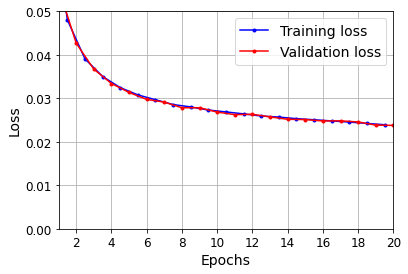

In [53]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [54]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

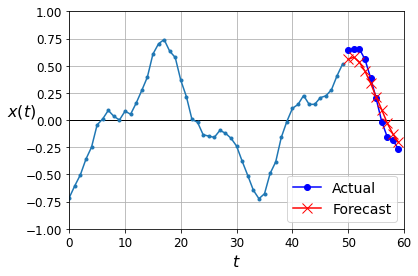

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## GRUs

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed_3 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 11s 31ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=

In [58]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.02378549985587597, 0.010262805968523026]

## Using One-Dimensional Convolutional Layers to Process Sequences

The following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using
a stride of 2. By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns. Note that we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2:

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          100       
                                                                 
 gru_2 (GRU)                 (None, None, 20)          2520      
                                                                 
 gru_3 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed_4 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 13s 19ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [=

In [62]:
model.evaluate(X_valid, Y_valid[:, 3::2])

63/63 [==============================] - 1s 8ms/step - loss: 0.0184 - last_time_step_mse: 0.0080


[0.018366245552897453, 0.00796824786812067]

# Natural-language processing

## Preparing text data

Vectorizing process using Python may be done as follows

In [63]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

vectorizer = Vectorizer()
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [64]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


In [65]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


However, using something like this wouldn’t be very performant. In practice, you’ll work with the Keras `TextVectorization` layer, which is fast and efficient and can be dropped directly into a `tf.data` pipeline or a Keras model.

In [66]:
from tensorflow.keras.layers import TextVectorization
# Configures the layer to return sequences of words encoded
# as integer indices.
text_vectorization = TextVectorization(
    output_mode="int",
)

By default, the TextVectorization layer will use the setting “convert to lowercase and remove punctuation” for text standardization, and “split on whitespace” for tokenization.

But importantly, you can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case.To index the vocabulary of a text corpus, just call the `adapt()` method of the layer with a `Dataset` object that yields strings, or just with a list of Python strings:

In [67]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)

Note that you can retrieve the computed vocabulary via `get_vocabulary()`—this can be useful if you need to convert text encoded as integer sequences back into words. The first two entries in the vocabulary are the mask token (index 0) and the OOV token (index 1). Entries in the vocabulary list are sorted by frequency, so with a realworld dataset, very common words like “the” or “a” would come first.

In [68]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

In [69]:
vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)


In [70]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


Before dive into the modeling part. We’ll demonstrate each approach on a well-known text classification benchmark: the IMDB movie review sentiment-classification dataset. Let’s process the raw
IMDB text data, just like you would do when approaching a new text-classification problem in the real world. 

https://ai.stanford.edu/~amaas/data/sentiment/

Let’s start by downloading the dataset from the Stanford page of Andrew Maas and uncompressing it

In [71]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.1M      0  0:00:07  0:00:07 --:--:-- 16.5M


There’s also a `train/unsup` subdirectory in there, which we don’t need. Let’s
delete it:

In [72]:
!rm -r aclImdb/train/unsup

Take a look at the content of a few of these text files. Whether you’re working with text data or image data, remember to always inspect what your data looks like before you dive into modeling it.

In [73]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Next, let’s prepare a validation set by setting apart 20% of the training text files in a new directory, aclImdb/val:

In [74]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Let’s create three Dataset objects for training, validation, and testing just like previous lab:

In [75]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


These datasets yield inputs that are TensorFlow `tf.string` tensors and targets that are `int32` tensors encoding the value “0” or “1.”

In [76]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'There\'s nothing really to dislike about "The Odd Couple," and it\'s no surprise that Jack Lemmon and Walter Matthau make a hugely winning comedic team. But there\'s something so underdeveloped about Neil Simon\'s adaptation of his hit stage play as to make it seem more like a skit on a sketch comedy show than a full-bodied film. I have not seen the play, but have to assume that the screen version is fairly faithful, since Simon wrote it, so the defects cannot be blamed on a stage-to-screen adaptation. There are some interesting ideas in this story--two recently divorced men who fall immediately into traditional married roles when they become roommates because neither knows any differently--that Simon never fully fleshes out. Still, there are many worse ways to kill a couple of hours.', shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


## Processing words as a set: The bag-of-words approach

### Single words (unigrams) with binary encoding

First, let’s process our raw text datasets with a `TextVectorization` layer so that they yield multi-hot encoded binary word vectors. Our layer will only look at single words (that is to say, unigrams). We will limit the vocabulary to the 20,000 most frequent words. Otherwise we’d be indexing every word in the training data— potentially tens of thousands of terms that only occur once or
twice and thus aren’t informative. In general, 20,000 is the right vocabulary size for text classification.

In [77]:
# Encode the output tokens as multi-hot binary vectors.
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)
# Prepare a dataset that only yields raw text inputs (no labels).
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [78]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [79]:
from tensorflow import keras
from tensorflow.keras import layers

# A densely connected NN
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="nadam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

Finally, let’s train and test our model.

In [80]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_8 (Dense)             (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 13s 16ms/step - loss: 0.3879 - accuracy: 0.8375 - val_loss: 0.2680 - val_accuracy: 0.8932
Epoch 2/10
625/625 [=======================

This gets us to a test accuracy of 88.4%: not bad!

### Bigrams with binary encoding

The `TextVectorization` layer can be configured to return arbitrary N-grams: bigrams, trigrams, etc. Just pass an `ngrams=N` argument as in the following listing.

In [81]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

In [82]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_10 (Dense)            (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 24s 37ms/step - loss: 0.3597 - accuracy: 0.8476 - val_loss: 0.2467 - val_accuracy: 0.8980
Epoch 2/10
625/625 [=====================

We’re now getting 89.5% test accuracy, a marked improvement! Turns out local order is pretty important.

### Bigrams with TF-IDF encoding

TF-IDF is so common that it’s built into the TextVectorization layer. All you need to do to start using it is to switch the output_mode argument to `tf_idf`.

In [91]:
from keras.layers import TextVectorization as TexVec

In [92]:
text_vectorization = TexVec(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

text_vectorization.adapt(text_only_train_ds)

InvalidArgumentError: ignored

In [ ]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

This gets us an 89.8% test accuracy on the IMDB classification task: it doesn’t seem to be particularly helpful in this case. However, for many text-classification datasets, it would be typical to see a one-percentage-point increase when using TF-IDF compared to plain binary encoding.

## Processing words as a sequence: The sequence model approach

Let’s try out a first sequence model in practice. First, let’s prepare datasets that return integer sequences. In order to keep a manageable input size, **we’ll truncate the inputs after the first 600 words.**

This is a reasonable choice, since the average review length is 233 words, and only 5% of reviews are longer than 600 words.

In [93]:
max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Next, let’s make a model. The simplest way to convert our integer sequences to vector sequences is to one-hot encode the integers (each dimension would represent one possible term in the vocabulary). On top of these one-hot vectors, we’ll add a simple bidirectional LSTM.

In [99]:
inputs = keras.Input(shape=(None,), dtype="int64") # One input is a sequence of integers
embedded = tf.one_hot(inputs, depth=max_tokens) # A 3D tensor of shape [batch size, time steps, embedding size]
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Classification layer
model = keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_5 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               5128448   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

A first observation: this model will train very slowly, especially compared to the lightweight model of the previous section. This is because our inputs are quite large: each input sample is encoded as a matrix of size `(600, 20000)` (600 words per sample, 20,000 possible words). That’s 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do.

Let's try word embedding. What makes a good word-embedding space depends heavily on your task: the perfect word-embedding space for an English-language movie-review sentiment-analysis model may look different from the perfect embedding space for an English-language legal-document classification model, because the importance of certain semantic relationships varies from task to task. It’s thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It’s about learning the weights of a layer: the Embedding layer.

In [102]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. The Embedding layer takes as input a rank-2 tensor of integers, of shape `(batch_size,sequence_length)`, where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape` (batch_size, sequence_length, embedding_dimensionality)`.

When you instantiate an Embedding layer, its weights (its internal dictionary of
token vectors) are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure—a kind of structure specialized for the specific problem for which you’re training your model. We will talk more about embedding in Lecture 7.

In [103]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

We’re still some way off from the results of our basic bigram model. Part of the reason why is simply that the model is looking at slightly less data:
the bigram model processed full reviews, while our sequence model truncates sequences after 600 words. One thing that’s slightly hurting model performance here is that our input sequences are full of zeros. This comes from our use of the `output_sequence_length=max_length` option in `TextVectorization` (with max_length equal to 600): **sentences longer than 600 tokens are truncated to a length of 600 tokens, and sentences shorter than 600 tokens are padded with zeros** at the end so that they can be concatenated together with other sequences to form contiguous batches.

We’re using a bidirectional RNN: two RNN layers running in parallel, with one processing the tokens in their natural order, and the other processing the same
tokens in reverse. **The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short**. The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

We need some way to tell the RNN that it should skip these iterations. There’s an API for that: *masking*. The Embedding layer is capable of generating a“mask” that corresponds to its input data. This mask is a tensor of ones and zeros (or `True/False` booleans), of shape `(batch_size, sequence_length)`,where the entry `mask[i, t]` indicates where timestep t of sample i should be skipped or not (the timestep will be skipped if `mask[i, t]` is 0 or False, and processed otherwise).

In [104]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs) # You can turn it on by passing mask_zero=True
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

## The Transformer encoder

The encoder part of transformer can be used for text classification—it’s a very generic module that ingests a sequence and learns to turn it into a more useful representation. Let’s implement a Transformer encoder using Kera subclassing API.

In [105]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # Size of the input token vectors
        self.dense_dim = dense_dim  # Size of the inner dense layer
        self.num_heads = num_heads  # Number of attention heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    # Computation goes in call().
    def call(self, inputs, mask=None): 
        # The mask that will be generated by the Embedding layer will be 2D, but
        # the attention layer expects to be 3D or 4D, so we expand its rank. 
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    # Implement serialization so we can save the model.
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

When you write custom layers, make sure to implement the `get_config` method: this enables the layer to be reinstantiated from its config dict, which is useful during model saving and loading.

To add positional encoding, we’ll do something simpler and more effective: we’ll learn positionembedding vectors the same way we learn to embed word indices. We’ll then proceed to add our position embeddings to the corresponding word embeddings, to obtain a position-aware word embedding. This technique is called **“positional embedding.”** Let’s implement it. **It is noted that vector. 
neural networks don’t like very large input values, or discrete input distributions** therefore simply adding a position information as interger is not a good idea.

In [106]:
class PositionalEmbedding(layers.Layer):
    # A downside of position embeddings is that the sequence length needs to be known in advance.
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Prepare an Embedding layer for the token indices.
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # And another one for the token positions
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        # Add both embedding vectors together
        return embedded_tokens + embedded_positions
    
    # Like the Embedding layer, this layer should be able to generate a
    # mask so we can ignore padding 0s in the inputs. The compute_mask
    # method will called automatically by the framework, and the
    # mask will get propagated to the next layer.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

All you have to do to start taking word order into account is swap the old Embedding layer with our position-aware version.

In [107]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                           